In [1]:
import glob

import pandas as pd
import awkward as ak
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
pz = lambda particle: particle.pt * np.sinh(particle.eta)
px = lambda particle: particle.pt * np.cos(particle.phi)
py = lambda particle: particle.pt * np.sin(particle.phi)

def get_mtt(array):
    # visible lepton sums
    vis_leptons = ak.concatenate([array.Electron, array.Muon, array.Tau], axis=1)[:, [0, 1]]

    vis_px1, vis_px2 = px(vis_leptons[:, 0]), px(vis_leptons[:, 1])
    vis_py1, vis_py2 = py(vis_leptons[:, 0]), py(vis_leptons[:, 1])
    vis_pz1, vis_pz2 = pz(vis_leptons[:, 0]), pz(vis_leptons[:, 1])
    
    vis_p1 = (vis_px1**2 + vis_py1**2 + vis_pz1**2)**0.5
    vis_p2 = (vis_px2**2 + vis_py2**2 + vis_pz2**2)**0.5
    
    vis_e1 = (vis_px1**2 + vis_py1**2 + vis_pz1**2 + vis_leptons[:, 0].mass**2)**0.5
    vis_e2 = (vis_px2**2 + vis_py2**2 + vis_pz2**2 + vis_leptons[:, 1].mass**2)**0.5

    # gen neutrinos
    nu_px = ak.sum(array.tau_nus.x, axis=1)
    nu_py = ak.sum(array.tau_nus.y, axis=1)
    nu_pz = ak.sum(array.tau_nus.z, axis=1)
    nu_e = (nu_px**2 + nu_py**2 + nu_pz**2)**0.5

    # regressed neutrinos
    reg_px = array.tautauNN_regression_output[:, 0] + array.tautauNN_regression_output[:, 3]
    reg_py = array.tautauNN_regression_output[:, 1] + array.tautauNN_regression_output[:, 4]
    reg_pz = array.tautauNN_regression_output[:, 2] + array.tautauNN_regression_output[:, 5]
    reg_e = (reg_px**2 + reg_py**2 + reg_pz**2)**0.5

    # vis + gen nu
    m_tt_gen = (
        (vis_e1 + vis_e2 + nu_e)**2 -
        (vis_px1 + vis_px2 + nu_px)**2 - 
        (vis_py1 + vis_py2 + nu_py)**2 - 
        (vis_pz1 + vis_pz2 + nu_pz)**2
    )**0.5
    
    # vis + reg nu
    m_tt_reg = (
        (vis_e1 + vis_e2 + reg_e)**2 -
        (vis_px1 + vis_px2 + reg_px)**2 - 
        (vis_py1 + vis_py2 + reg_py)**2 - 
        (vis_pz1 + vis_pz2 + reg_pz)**2
    )**0.5

    return m_tt_gen, m_tt_reg

In [3]:
PATTERN = "/nfs/dust/cms/user/yamralim/cf_cache/hbt_store/analysis_hbt/cf.UniteColumns/run2_2017_nano_uhh_v11/{}/nominal/calib__none/sel__default/prod__z_fractions/dev3_allz/data_*.parquet"

dfs = []

z_cols = ["z_gen_pos", "z_gen_neg", "z_rec_neg", "z_rec_pos", "dm_neg", "dm_pos"]
mtt_cols = ["Tau", "Electron", "Muon", "tau_nus", "tautauNN_regression_output"]

for process_name, df_name in [
    ("dy_lep_m50_amcatnlo", "dy"),
    ("tt_dl_powheg", "tt"),
    ("hh_ggf_bbtautau_madgraph", "hh"),
]:
    #print(f"checking {process_name}")
    for path in glob.glob(PATTERN.format(process_name)):
        #print(f"reading {path}")
        data = ak.from_parquet(path, columns=z_cols + mtt_cols + ["category_ids"])
        mtt_gen, mtt_reg = get_mtt(data)
        df = ak.to_dataframe(data[z_cols])
        df["mtt_gen"] = mtt_gen
        df["mtt_reg"] = mtt_reg
        df["process"] = df_name
        dfs.append(df)
df = pd.concat(dfs)

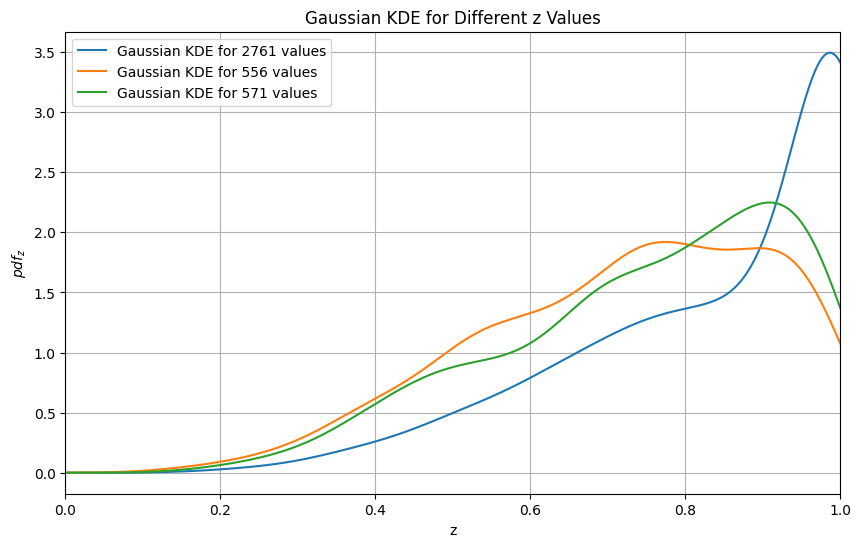

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde, norm

# Filter the main data
filtered_df = df[(df["dm_pos"] == 10) & (df["dm_neg"] == 1)]

# Normalize the data to the range of [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

# Function to calculate the PDF values using Gaussian distribution
def gaussian_pdf(z_vals, x):
    kde = gaussian_kde(z_vals, bw_method=0.3)  # Kernel density estimation with bandwidth
    pdf = kde.evaluate(x)
    return pdf

# Function to plot the Gaussian PDF using KDE for better structure
def plot_gaussian_kde(z_vals, x):
    y = gaussian_pdf(z_vals, x)
    plt.plot(x, y, label=f'Gaussian KDE for {len(z_vals)} values')

# Range for x values from 0 to 1
x = np.linspace(0.0, 1.0, 1000)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot Gaussian KDE for filtered data
plot_gaussian_kde(filtered_df[filtered_df["process"] == "tt"]["z_gen_pos"].tolist(), x)
plot_gaussian_kde(filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist(), x)
plot_gaussian_kde(filtered_df[filtered_df["process"] == "dy"]["z_gen_pos"].tolist(), x)

plt.xlim((0, 1))
plt.xlabel('z')
plt.ylabel('$pdf_{z}$')
plt.title('Gaussian KDE for Different z Values')
plt.legend()
plt.grid(True)
plt.show()


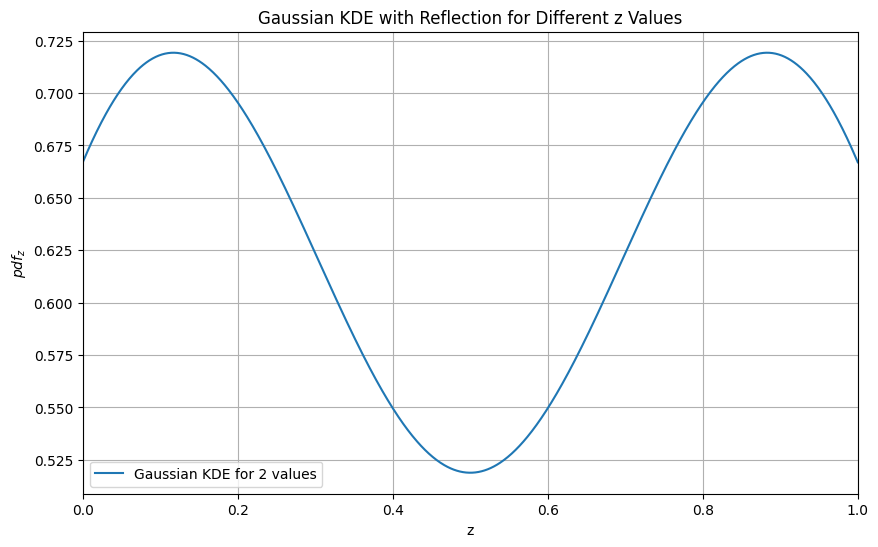

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde


# Filter the main data
filtered_df = df[(df["dm_pos"] == 10) & (df["dm_neg"] == 1)]

# Normalize the data to the range of [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

# Function to calculate the PDF values using Gaussian KDE and handle out-of-bounds reflection
def gaussian_kde_pdf(z_vals, x):
    kde = gaussian_kde(z_vals, bw_method=0.5)  # Kernel density estimation with bandwidth
    pdf = kde.evaluate(x)
    
    # Reflect the out-of-bounds parts back into the range [0, 1]
    pdf += kde.evaluate(2 - x) * (x > 1)  # Reflect values greater than 1
    pdf += kde.evaluate(-x) * (x < 0)  # Reflect values less than 0
    
    return pdf

# Function to plot the Gaussian KDE with out-of-bounds reflection
def plot_gaussian_kde(z_vals, x):
    y = gaussian_kde_pdf(z_vals, x)
    plt.plot(x, y, label=f'Gaussian KDE for {len(z_vals)} values')

# Range for x values from 0 to 1
x = np.linspace(0.0, 1.0, 1000)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot Gaussian KDE for filtered data
#plot_gaussian_kde(filtered_df[filtered_df["process"] == "tt"]["z_gen_pos"].tolist(), x)
#plot_gaussian_kde(filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist(), x)
#plot_gaussian_kde(filtered_df[filtered_df["process"] == "dy"]["z_gen_pos"].tolist(), x)
plot_gaussian_kde([0.1, 0.9], x)

plt.xlim((0, 1))
plt.xlabel('z')
plt.ylabel('$pdf_{z}$')
plt.title('Gaussian KDE with Reflection for Different z Values')
plt.legend()
plt.grid(True)
plt.show()


4.753242440043272


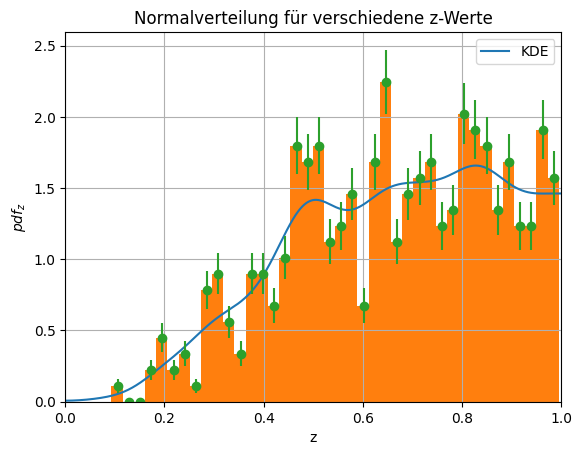

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from functools import partial

# Beispielhafte Erstellung eines DataFrames (falls nicht vorhanden)
# df = pd.read_csv('your_data.csv')  # Beispiel zum Laden Ihrer Daten

# Filtern der Hauptdaten
filtered_df = df[(df["dm_pos"] == 0) & (df["dm_neg"] == 0)]

# Normieren der Daten auf den Bereich von [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

# Bereich für x-Werte von 0 bis 1
x = np.linspace(0, 1, 1000)

mu = 0.1  # Beispielwert für den Mittelwert
sigma = 0.1
# Berechnung der PDF der Normalverteilung
pdf = norm.pdf(x, mu, sigma)



# KDE-Funktion basierend auf der Normalverteilung
def kde(z_vals, sigma=0.1, flip_threshold=0.001):
    mu_flip_left = -norm.ppf(flip_threshold, loc=0, scale=sigma)
    mu_flip_right = 1 - mu_flip_left
    def func(x):
        values = []
        for z in z_vals:
            mu = z  # Mittelwert ist der jeweilige z-Wert
            # define up to three pdfs
            pdfs = []
            # central gauss
            pdfs.append(partial(norm.pdf, loc=mu, scale=sigma))
            # optional left tail if cut off integral is below 0.001
            if mu < mu_flip_left:
                pdfs.append(partial(norm.pdf, loc=-mu, scale=sigma))
            # right tail
            if mu > mu_flip_right:
                pdfs.append(partial(norm.pdf, loc=2 - mu, scale=sigma))

            # evaluate and fill
            values.extend([pdf(x) for pdf in pdfs])
        return sum(values) / len(z_vals)
    return func

# Plot der KDE
def plot_kde(x, *args, **kwargs):
    k = kde(*args, **kwargs)
    y = k(x)
    plt.plot(x, y, label=f'KDE')
    return k

# Beispiele für KDE Plots
#plot_kde(x, z_vals=[0.1, 0.9], sigma=0.05 )
k = plot_kde(x, z_vals=filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist(), sigma=0.05)
#plt.hist(filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist(), density=True, bins=40)
counts, bins, _= plt.hist(filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist(), density=True, bins=40)
errors = np.sqrt(counts/np.sum(counts))
plt.errorbar(bins[:-1]+ 0.0125, counts, yerr=errors, fmt='o')
chi = 1/ 40 * sum([((counts[i] -k(0.0125+i*0.025))/ errors[i])**2 for i in range(40) if counts[i]])
print(chi)
#plot_kde(filtered_df[filtered_df["process"] == "dy"]["z_gen_pos"].tolist(), x)
#plt.plot(x, norm.pdf(x, loc=0.1, scale=0.05))
#plt.plot(x, norm.pdf(x, loc=0.9, scale=0.05))
#plt.yscale("log")
plt.xlim((0, 1))
plt.xlabel('z')
plt.ylabel('$pdf_{z}$')
plt.title('Normalverteilung für verschiedene z-Werte')
plt.legend()
plt.grid(True)
plt.show()


5.743299748923732


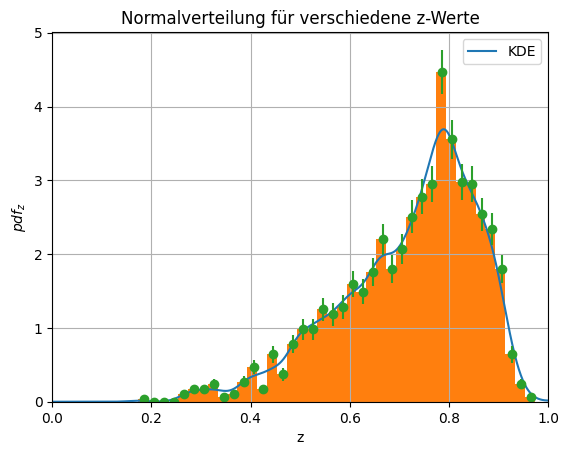

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from functools import partial

# Bereich für x-Werte von 0 bis 1
x = np.linspace(0, 1, 1000)

# KDE-Funktion basierend auf der Normalverteilung
def kde(z_vals, sigma=0.1, flip_threshold=0.001):
    mu_flip_left = -norm.ppf(flip_threshold, loc=0, scale=sigma)
    mu_flip_right = 1 - mu_flip_left
    def func(x):
        values = []
        for z in z_vals:
            mu = z  # Mittelwert ist der jeweilige z-Wert
            # define up to three pdfs
            pdfs = []
            # central gauss
            pdfs.append(partial(norm.pdf, loc=mu, scale=sigma))
            # optional left tail if cut off integral is below 0.001
            if mu < mu_flip_left:
                pdfs.append(partial(norm.pdf, loc=-mu, scale=sigma))
            # right tail
            if mu > mu_flip_right:
                pdfs.append(partial(norm.pdf, loc=2 - mu, scale=sigma))

            # evaluate and fill
            values.extend([pdf(x) for pdf in pdfs])
        return sum(values) / len(z_vals)
    return func

# Plot der KDE
def plot_kde(x, *args, **kwargs):
    k = kde(*args, **kwargs)
    y = k(x)
    plt.plot(x, y, label=f'KDE')
    return k

# Beispiele für KDE Plots
k = plot_kde(x, z_vals=filtered_df[filtered_df["process"] == "hh"]["z_rec_pos"].tolist(), sigma=0.02)
counts, bins, _ = plt.hist(filtered_df[filtered_df["process"] == "hh"]["z_rec_pos"].tolist(), density=True, bins=40)
errors = np.sqrt(counts / np.sum(counts))
plt.errorbar(bins[:-1] + 0.0125, counts, yerr=errors, fmt='o')
chi = 1 / 40 * sum([((counts[i] - k(0.0125 + i * 0.025)) / errors[i]) ** 2 for i in range(40) if counts[i]])
print(chi)

plt.xlim((0, 1))
plt.xlabel('z')
plt.ylabel('$pdf_{z}$')
plt.title('Normalverteilung für verschiedene z-Werte')
plt.legend()
plt.grid(True)
plt.show()


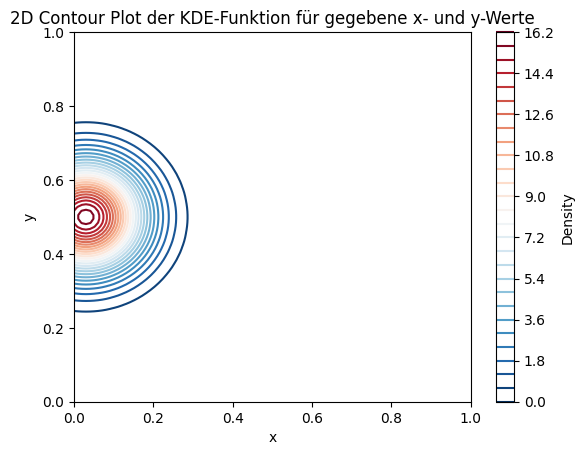

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from functools import partial

# Daten für die x- und y-Achse
# z_vals = np.array([[0.1, 0.15], [0.5, 0.4], [0.75, 0.3], [0.85, 0.9], [0.05, 0.95]])
z_vals = np.array([[0.03, 0.5]])


# Gitter von x und y
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)

def kde(z_vals, sigma=0.01, flip_threshold=0.01):
    mu_flip_low = -norm.ppf(flip_threshold, loc=0, scale=sigma)
    mu_flip_high = 1 - mu_flip_low
    # print("thresholds for flip:", mu_flip_low, mu_flip_high)

    # determine pdfs
    pdfs = []
    for zx, zy in z_vals:
        # central pdf
        multi_norm = lambda zx, zy: multivariate_normal([zx, zy], [[sigma, 0], [0, sigma]])
        pdfs.append(multi_norm(zx, zy).pdf)
        # optional left tail if cut off integral is below 0.001
        if zx <= mu_flip_low:
            pdfs.append(multi_norm(-zx, zy).pdf)
        # right tail
        if zx >= mu_flip_high:
            pdfs.append(multi_norm(2 - zx, zy).pdf)
        # bottom tail
        if zy <= mu_flip_low:
            pdfs.append(multi_norm(zx, -zy).pdf)
        # top tail
        if zy >= mu_flip_high:
            pdfs.append(multi_norm(zx, 2 - zy).pdf)
    
    def func(vals):
        return sum(pdf(vals) for pdf in pdfs) / len(z_vals)
    
    return func

# Funktion zur Berechnung der KDE-Werte auf einem Gitter
def calculate_kde_grid(z_vals, vals):
    kde_func = kde(z_vals)
    return kde_func(vals)

# Berechnung der KDE-Werte auf dem Gitter
Z = calculate_kde_grid(z_vals, np.dstack((X, Y)))

# Erstelle den Contour-Plot
plt.contour(X, Y, Z, levels=30, cmap="RdBu_r")
plt.colorbar(label='Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Contour Plot der KDE-Funktion für gegebene x- und y-Werte')
plt.show()




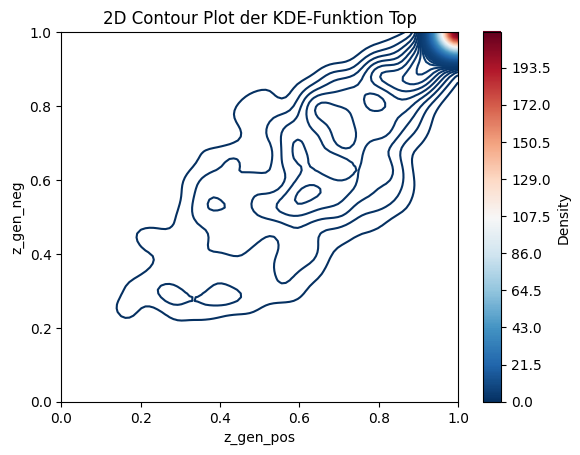

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from functools import partial
# Filtern der Hauptdaten
filtered_df = df[(df["dm_pos"] == 0) & (df["dm_neg"] == 0)]

# Normieren der Daten auf den Bereich von [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

z_vals = list(zip(filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist(), 
                 filtered_df[filtered_df["process"] == "hh"]["z_gen_neg"].tolist()))
#z_vals = np.array([[0.1, 0.15], [0.5, 0.4], [0.75, 0.3], [0.85, 0.9], [0.05, 0.95]])
# Gitter von x und y
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)

def kde(z_vals, sigma=0.001, flip_threshold=0.01):
    mu_flip_low = -norm.ppf(flip_threshold, loc=0, scale=sigma)
    mu_flip_high = 1 - mu_flip_low
    # print("thresholds for flip:", mu_flip_low, mu_flip_high)

    # determine pdfs
    pdfs = []
    for zx, zy in z_vals:
        # central pdf
        multi_norm = lambda zx, zy: multivariate_normal([zx, zy], [[sigma, 0], [0, sigma]])
        pdfs.append(multi_norm(zx, zy).pdf)
        # optional left tail if cut off integral is below 0.001
        if zx <= mu_flip_low:
            pdfs.append(multi_norm(-zx, zy).pdf)
        # right tail
        if zx >= mu_flip_high:
            pdfs.append(multi_norm(2 - zx, zy).pdf)
        # bottom tail
        if zy <= mu_flip_low:
            pdfs.append(multi_norm(zx, -zy).pdf)
        # top tail
        if zy >= mu_flip_high:
            pdfs.append(multi_norm(zx, 2 - zy).pdf)
    
    def func(vals):
        return sum(pdf(vals) for pdf in pdfs) / len(z_vals)
    
    return func

# Funktion zur Berechnung der KDE-Werte auf einem Gitter
def calculate_kde_grid(z_vals, vals):
    kde_func = kde(z_vals)
    return kde_func(vals)

# Berechnung der KDE-Werte auf dem Gitter
Z = calculate_kde_grid(z_vals, np.dstack((X, Y)))
#shape = np.dstack((X, Y))
#print(shape)
# Erstelle den Contour-Plot
plt.contour(X, Y, Z, levels=500, cmap="RdBu_r")
plt.colorbar(label='Density')
plt.xlabel('z_gen_pos')
plt.ylabel('z_gen_neg')
plt.title('2D Contour Plot der KDE-Funktion Top')
plt.show()

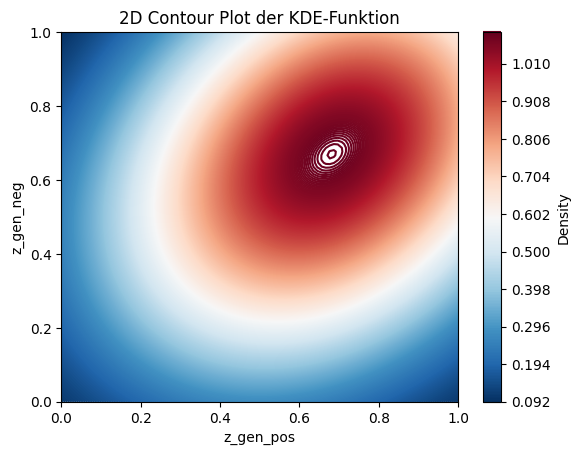

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from functools import partial

# Filtern der Hauptdaten
filtered_df = df[(df["dm_pos"] == 0) & (df["dm_neg"] == 0)]

# Normieren der Daten auf den Bereich von [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

z_vals = list(zip(filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist(), 
                 filtered_df[filtered_df["process"] == "hh"]["z_gen_neg"].tolist()))

# Gitter von x und y
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)

def sigma_from_density(density, min_sigma=0.001, max_sigma=0.1):
    """Berechnet sigma basierend auf der Dichte."""
    return max(min_sigma, min(max_sigma, 1 / (density + 1)))

def kde(z_vals, x_grid, y_grid, flip_threshold=0.01):
    # Berechne Dichte der Punkte
    hist, xedges, yedges = np.histogram2d(
        [z[0] for z in z_vals], [z[1] for z in z_vals], bins=(x_grid, y_grid)
    )
    density = hist.T

    def dynamic_sigma_func(zx, zy):
        # Finde den entsprechenden Bin
        x_idx = np.clip(np.digitize(zx, xedges) - 1, 0, len(xedges) - 2)
        y_idx = np.clip(np.digitize(zy, yedges) - 1, 0, len(yedges) - 2)
        # Berechne die Dichte und Sigma
        point_density = density[y_idx, x_idx]
        return sigma_from_density(point_density)

    mu_flip_low = -norm.ppf(flip_threshold, loc=0, scale=0.001)  # initial sigma
    mu_flip_high = 1 - mu_flip_low

    pdfs = []
    for zx, zy in z_vals:
        sigma = dynamic_sigma_func(zx, zy)
        multi_norm = lambda zx, zy: multivariate_normal([zx, zy], [[sigma, 0], [0, sigma]])
        pdfs.append(multi_norm(zx, zy).pdf)

        if zx <= mu_flip_low:
            pdfs.append(multi_norm(-zx, zy).pdf)
        if zx >= mu_flip_high:
            pdfs.append(multi_norm(2 - zx, zy).pdf)
        if zy <= mu_flip_low:
            pdfs.append(multi_norm(zx, -zy).pdf)
        if zy >= mu_flip_high:
            pdfs.append(multi_norm(zx, 2 - zy).pdf)

    def func(vals):
        return sum(pdf(vals) for pdf in pdfs) / len(z_vals)

    return func

# Funktion zur Berechnung der KDE-Werte auf einem Gitter
def calculate_kde_grid(z_vals, X, Y):
    kde_func = kde(z_vals, x_grid, y_grid)
    positions = np.dstack((X, Y))
    Z = np.apply_along_axis(kde_func, 2, positions)
    return Z

# Berechnung der KDE-Werte auf dem Gitter
Z = calculate_kde_grid(z_vals, X, Y)

# Erstelle den Contour-Plot
plt.contour(X, Y, Z, levels=500, cmap="RdBu_r")
plt.colorbar(label='Density')
plt.xlabel('z_gen_pos')
plt.ylabel('z_gen_neg')
plt.title('2D Contour Plot der KDE-Funktion')
plt.show()



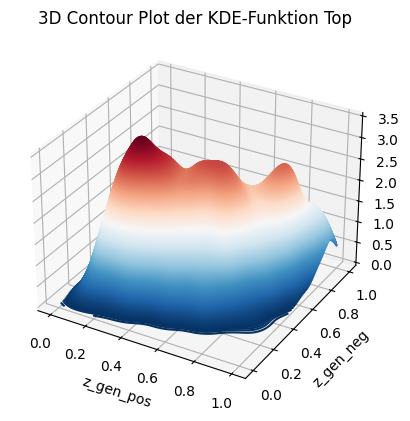

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from functools import partial
# Filtern der Hauptdaten
filtered_df = df[
(df["dm_pos"] == 1)
#((df["dm_pos"] == 11) | (df["dm_pos"] == 10))
& 
(df["dm_neg"] == -1)
#((df["dm_neg"] == 11) | (df["dm_neg"] == 10))
]

# Normieren der Daten auf den Bereich von [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

z_vals = list(zip(filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist(), 
                 filtered_df[filtered_df["process"] == "hh"]["z_gen_neg"].tolist()))
#z_vals = np.array([[0.1, 0.15], [0.5, 0.4], [0.75, 0.3], [0.85, 0.9], [0.05, 0.95]])
# Gitter von x und y
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)

def kde(z_vals, sigma=0.002, flip_threshold=0.01):
    mu_flip_low = -norm.ppf(flip_threshold, loc=0, scale=sigma)
    mu_flip_high = 1 - mu_flip_low
    # print("thresholds for flip:", mu_flip_low, mu_flip_high)

    # determine pdfs
    pdfs = []
    for zx, zy in z_vals:
        # central pdf
        multi_norm = lambda zx, zy: multivariate_normal([zx, zy], [[sigma, 0], [0, sigma]])
        pdfs.append(multi_norm(zx, zy).pdf)
        # optional left tail if cut off integral is below 0.001
        if zx <= mu_flip_low:
            pdfs.append(multi_norm(-zx, zy).pdf)
        # right tail
        if zx >= mu_flip_high:
            pdfs.append(multi_norm(2 - zx, zy).pdf)
        # bottom tail
        if zy <= mu_flip_low:
            pdfs.append(multi_norm(zx, -zy).pdf)
        # top tail
        if zy >= mu_flip_high:
            pdfs.append(multi_norm(zx, 2 - zy).pdf)
    
    def func(vals):
        return sum(pdf(vals) for pdf in pdfs) / len(z_vals)
    
    return func

# Funktion zur Berechnung der KDE-Werte auf einem Gitter
def calculate_kde_grid(z_vals, vals):
    kde_func = kde(z_vals)
    return kde_func(vals)

# Berechnung der KDE-Werte auf dem Gitter
Z = calculate_kde_grid(z_vals, np.dstack((X, Y)))
#shape = np.dstack((X, Y))
#print(shape)
# Erstelle den Contour-Plot
ax = plt.figure().add_subplot(projection='3d')
ax.contour(X, Y, Z, levels=500, cmap="RdBu_r")
#ax.colorbar(label='Density')
plt.xlabel('z_gen_pos')
plt.ylabel('z_gen_neg')
plt.title('3D Contour Plot der KDE-Funktion Top')
plt.show()